# Problema 1

Para este problema se les pide implementar funciones que analizan los datos obtenidos de un detector de formas en imágenes.

Usted debe realizar las siguientes tareas:

1. Instalar todos los módulos y librerías necesarias.
2. Analizar y entender el código.
3. Implementar funciones **detectShape**, **detectColor** y **detectOppositeColor**, con sus respectivos parámetros y valores de retorno. Solo puede modificar la celda correspondiente a cada función.
4. Modificar valores específicos dentro del código principal. Estos valores están marcados con **"#<-Can be modified"**.
5. Analizar resultados de la imagen generada y matrices de confusión. Utilizar diferentes valores para realizar su analisis.

## Importar Modulos a Utilizar

In [1]:
import cv2
import math
import Utilities as ut
from scipy.spatial import distance as dist
import numpy as np
import imutils
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Detectar Forma

In [2]:
# Input: Contour cntr; Margin of error for comparations margin.
# Output: Tuple (shape,triangle,quad):
#        shape: Name of polygon respect with the number of sides.
#               Values -> "","no shape","triangulo","cuadrilatero","pentagono",
#                         "hexagono","heptagono","octogono","eneagono","decagono",
#                         "endecagono","dodecagono","circulo"
#        triangle: If figure is triangle, denomination in respect to number of equal sides.
#                  Values -> "no triangulo","equilatero","isosceles","escaleno",
#        quad: If figure is quadrilateral, denomination in the next list of values.
#                  Values -> "no cuadrilatero","otro","paralelogramo","cuadrado","rectangulo",
#                            "rombo","romboide","trapecio","trapezoide"
def detectShape(cntr,margin):
    shape = "no shape"
    triangle = "no triangulo"
    quad = "no cuadrilatero"
    
    return shape,triangle,quad

# Function that could be defined to determine the triangle type.
# Should be called from detectShape
def triangle_type(cntr, margin):
    return "no triangulo"

# Function that could be defined to determine the quadrilateral type.
# Should be called from detectShape
def quadrilateral_type(cntr, margin):
    return "no cuadrilatero"

## Definir Diccionario de Colores en formato RGB y Arreglo en formato LAB

In [3]:
# Define dictionary with RGB formated colors.
colorDictionary = { 
    "rojo": (255, 0, 0),
    "verde": (0, 255, 0),
    "azul": (0, 0, 255)
} #<-Can be modified

# Create an array (matrix) to save colors and transform them to LAB format later.
labColors = np.zeros((len(colorDictionary), 1, 3), dtype="uint8")
# Create a list to save corresponding color names.
labColorNames = []

# Iterate in color dictionary and save values in respective lists.
for (i, (name, rgb)) in enumerate(colorDictionary.items()):
    labColors[i] = rgb
    labColorNames.append(name)

# Convert array to LAB color format
labColors = cv2.cvtColor(labColors, cv2.COLOR_RGB2LAB)

## Detectar Color

In [4]:
# Input: Image image; Contour c.
# Output: Name of color from color dictionary with minimal distance to contour's color.
#         Values -> "rojo","verde","azul","amarillo","fucsia","cyan","blanco"
def detectColor(image, c):
    # Create contour mask to ignore rest of the image.
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    mask = cv2.erode(mask, None, iterations=2)

    # Obtain mean value of contour internal color.
    mean = cv2.mean(image, mask=mask)[:3]

    return "rojo"

## Detectar Color Opuesto

In [5]:
# Input: Image image; Contour c.
# Output: Name of color from color dictionary with maximal distance to contour's color.
#         Values -> "rojo","verde","azul","amarillo","fucsia","cyan","blanco"
def detectOppositeColor(image, c):
    # Create contour mask to ignore rest of the image.
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    mask = cv2.erode(mask, None, iterations=2)

    # Obtain mean value of contour internal color.
    mean = cv2.mean(image, mask=mask)[:3]
    
    return "rojo"

## Definir Nombre de Imagen y Cargar Imagen

In [6]:
fileNames = ["formas","formas2","triangulos","triangulos2","cuadrilateros"]
imageName = fileNames[0] #<-Can be modified

# OpenCV loads image in BRG format
image = cv2.imread(imageName+".png")

## Manipular Imagen

In [7]:
# OpenCv uses BRG format, convert it to RGB
RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize image
resizeRatio = 0.5 #<-Can be modified
resized = imutils.resize(image, width=int(resizeRatio*image.shape[1]))

# Blur image slightly
blurred = cv2.GaussianBlur(resized, (5, 5), 0)

# Convert blurred image grayscale and the L*a*b* color spaces
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)

# Use a threshold to create a two colored image 
minimumThreshold = 10 #<-Can be modified
thresh = cv2.threshold(gray, minimumThreshold, 255, cv2.THRESH_BINARY)[1]

## Encontrar Contornos

In [8]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]

## Inicializar Listas

In [9]:
results = list()
shapes = list()
colors = list()
triangles = list()
quads = list()

## Iterar en Contornos, Detectar Forma y Color.

In [10]:
i = 1
# Loop over the contours
for c in cnts:
    # Compute the center of the contour
    M = cv2.moments(c)
    cX = int((M["m10"] / M["m00"]) / resizeRatio)
    cY = int((M["m01"] / M["m00"]) / resizeRatio)

    # Calculate contour perimeter
    peri = cv2.arcLength(c, True)

    # Aproximate contour rects
    approximationMargin = 0.05 #<-Can be modified
    approx = cv2.approxPolyDP(c, approximationMargin * peri, True)


    # Detect form and color of contour(IMPLEMENTAR!)
    equalityMargin = 0.3 #<-Can be modified
    shape,triangle,quad = detectShape(approx,equalityMargin)
    color = detectColor(lab, c)
    opcolor = colorDictionary[detectOppositeColor(lab, c)]
    
    # Multiply coordinates with resize ratio
    approx = approx.astype("float")
    approx /= resizeRatio
    approx = approx.astype("int")

    # Draw detected approximate figure in the image
    cv2.drawContours(image, [approx], -1, (opcolor[2],opcolor[1],opcolor[0]), 4)

    # Draw identifier in the center of contour
    text = str(i)
    textsize = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 3, 5);
    opcolor = colorDictionary[detectOppositeColor(lab, c)]
    cv2.putText(image, text, (cX-int(textsize[0][0]/2), cY+int(textsize[0][1]/2)),
                cv2.FONT_HERSHEY_SIMPLEX, 3, (opcolor[2],opcolor[1],opcolor[0]), 4)

    # Save results in lists
    results.append((text,shape,color,triangle,quad))
    shapes.append(shape)
    colors.append(color)
    triangles.append(triangle)
    quads.append(quad)

    i+=1

## Save and plot image

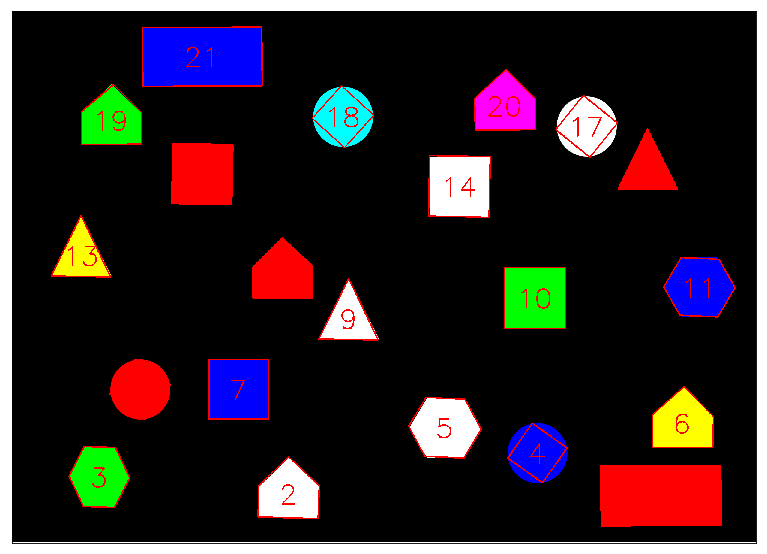

In [11]:
# OpenCv uses BRG format, convert it to RGB
RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Save image
cv2.imwrite('generated_{}.png'.format(imageName),image)

# Plot image
fig=plt.figure(figsize=(12, 12), dpi= 80)
plt.xticks([]), plt.yticks([])
plt.imshow(RGB_img)
plt.show()

## Save results in file

In [12]:
# Save results
f = open('generated_{}.txt'.format(imageName),"w")
for r in results:
    f.write(','.join(list(r))+'\n')
f.close()

## Obtain real data set from file

In [13]:
f =  open('{}.txt'.format(imageName))
trueresults = list()
trueshapes = list()
truecolors = list()
truetriangles = list()
truequads = list()
for line in f:
    tr = tuple(line.strip().split(','))
    trueresults.append(tr)
    trueshapes.append(tr[1])
    truecolors.append(tr[2])
    truetriangles.append(tr[3])
    truequads.append(tr[4])

## Plot general shape confusion matrix

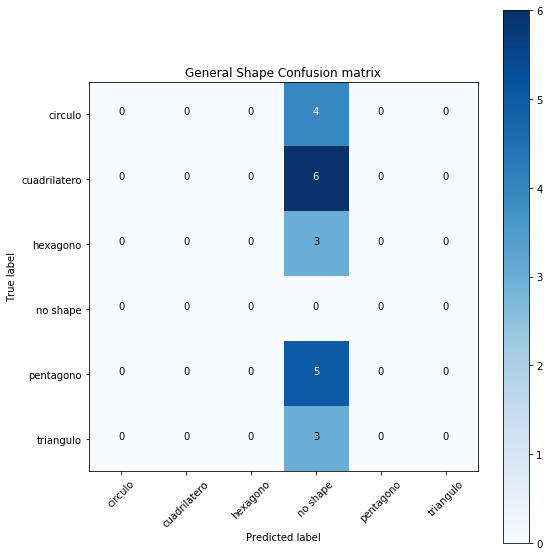

In [14]:
#Define true data and prediction for matrix
truedata = trueshapes
prediction = shapes

#Calculate confusion matrix
cnf = confusion_matrix(truedata,prediction)
clases = list(set(truedata+prediction))
clases.sort()

#Plot confusion matrix
ut.plot_confusion_matrix(cnf, classes=clases, normalize=False, title='General Shape Confusion matrix')

## Plot color confusion matrix

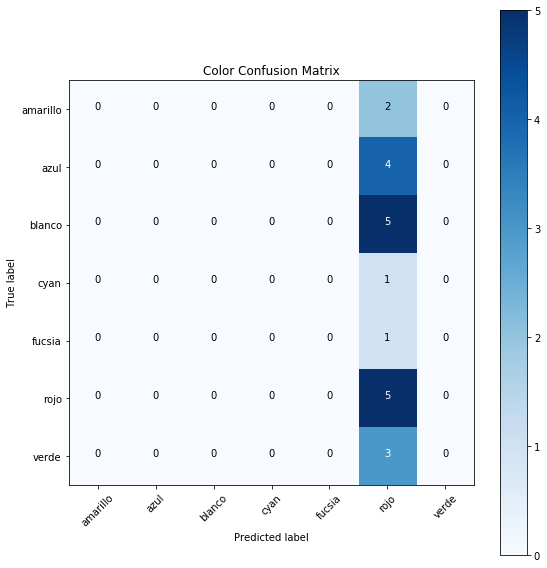

In [15]:
#Define true data and prediction for matrix
truedata = truecolors
prediction = colors

#Calculate confusion matrix
cnf = confusion_matrix(truedata,prediction)
clases = list(set(truedata+prediction))
clases.sort()

#Plot confusion matrix
ut.plot_confusion_matrix(cnf, classes=clases, normalize=False, title='Color Confusion Matrix')

## Plot triangular shape confusion matrix

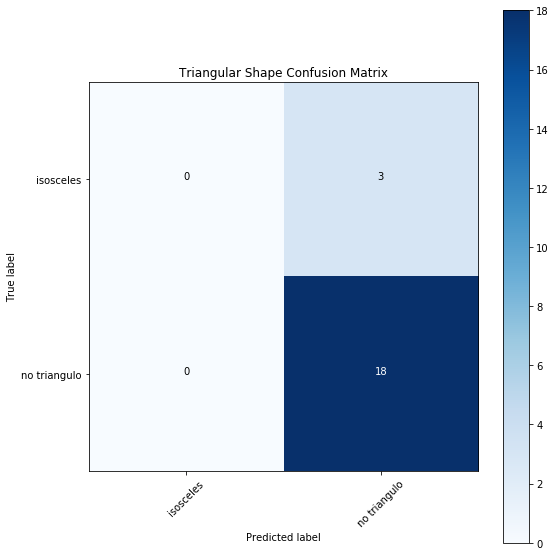

In [16]:
#Define true data and prediction for matrix
truedata = truetriangles
prediction = triangles

#Calculate confusion matrix
cnf = confusion_matrix(truedata,prediction)
clases = list(set(truedata+prediction))
clases.sort()

#Plot confusion matrix
ut.plot_confusion_matrix(cnf, classes=clases, normalize=False, title='Triangular Shape Confusion Matrix')

## Plot quadrilateral shape confusion matrix

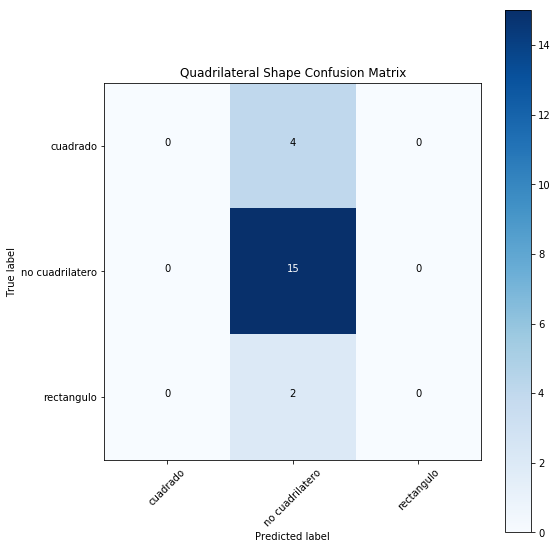

In [17]:
#Define true data and prediction for matrix
truedata = truequads
prediction = quads

#Calculate confusion matrix
cnf = confusion_matrix(truedata,prediction)
clases = list(set(truedata+prediction))
clases.sort()

#Plot confusion matrix
ut.plot_confusion_matrix(cnf, classes=clases, normalize=False, title='Quadrilateral Shape Confusion Matrix')